<img src="https://opensarlab-docs.asf.alaska.edu/opensarlab-notebook-assets/notebook_images/UAFLogo_A_647.png" width="170" align="right" />

This notebook is prepared as part of the GEOS 636 class project by [Amrit Thapa](https://amrit-thapa-2044.github.io/). It demonstrates users to explore output of MintPy: InSAR time series tool.





In [ ]:
# Load necessary packages


import os
import numpy as np
import pandas as pd
import geopandas as gpd
# !pip install rasterio

import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import h5py
import xarray as xr
import datetime as dt

# pyplot needed to plot the dataset, but animation only needed much further down.
from matplotlib import pyplot as plt, animation,rc,colors

# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display


Let's import the InSAR output from google drive.

In [ ]:
# path to InSAR data
mintpy_dir='/content/drive/MyDrive/Colab Notebooks/class_project_geos_636'
os.chdir(mintpy_dir)

insar_ts_file='timeseries.h5' # insar result from insar time series analysis


Convert h5 to xarray: Xarray is very handly to work with raster time series data. So, let's convert inverted time series to xarray.

In [ ]:
# read data
disp_df = xr.open_dataset(insar_ts_file, engine='h5netcdf', phony_dims='sort', decode_coords="all")

# rename variables
disp_df = disp_df.rename({'date': 'dstring',
                          'timeseries': 'displacement'})

# rename dims
disp_df = disp_df.rename_dims({'phony_dim_0':'date',
                               'phony_dim_1':'latitude',
                               'phony_dim_2':'longitude'})

# use the 'date' data variable to create date list
date_list = []
for i in (disp_df['dstring'].values):
    date_list.append(dt.datetime.strptime(str(i)[2:10], '%Y%m%d'))

# rebuild coordinates
disp_df = disp_df.assign_coords({'date': ('date', np.array(date_list)),
                                 'latitude': ('latitude', coord_range(disp_df, 'lat')),
                                 'longitude': ('longitude', coord_range(disp_df, 'lon'))})



Visualize the data.

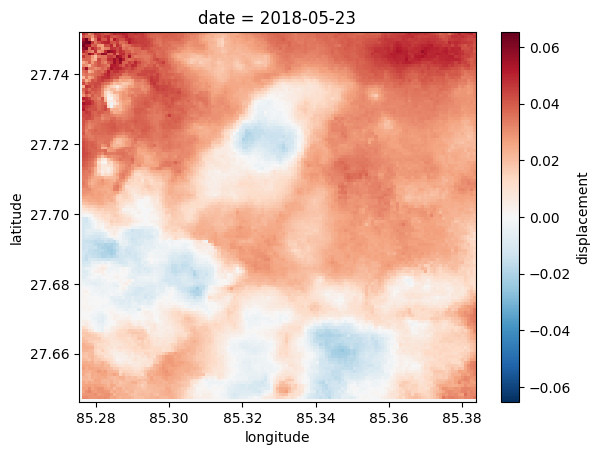

In [ ]:
disp_df.isel(date=10).displacement.plot.imshow()

In [ ]:
# get details of the data
disp_df

<xarray.Dataset>
Dimensions:       (date: 29, latitude: 126, longitude: 129)
Coordinates:
  * date          (date) datetime64[ns] 2018-01-23 2018-02-04 ... 2018-12-25
  * latitude      (latitude) float64 27.75 27.75 27.75 ... 27.65 27.65 27.65
  * longitude     (longitude) float64 85.28 85.28 85.28 ... 85.38 85.38 85.38
Data variables:
    bperp         (date) float32 ...
    dstring       (date) |S8 b'20180123' b'20180204' ... b'20181213' b'20181225'
    displacement  (date, latitude, longitude) float32 ...
Attributes: (12/66)
    ALOOKS:                                   7
    ANTENNA_SIDE:                             -1
    CENTER_LINE_UTC:                          44541.0
    EARTH_RADIUS:                             6337286.638938101
    END_DATE:                                 20201226
    FILE_LENGTH:                              126
    ...                                       ...
    mintpy.networkInversion.weightFunc:       var
    mintpy.reference.date:                    20180123
    mintpy.reference.lalo:                    27.682,85.288
    orbitDirection:                           ASCENDING
    slantRangeSpacing:                        2.329562187194824
    startRange:                               798980.125

Extract data for any geographical location you are interested in.

---



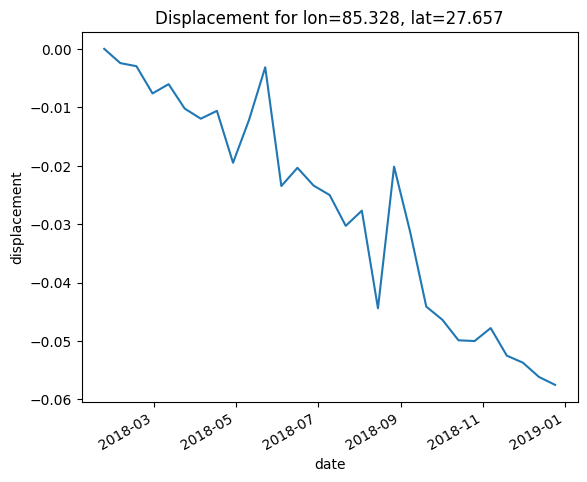

In [ ]:
lon_value = 85.328 #
lat_value = 27.657

# Extract the data for the specified lon and lat
subset = disp_df.sel(latitude=lat_value, longitude=lon_value,method='nearest')

# Plot the displacement as a function of date
subset['displacement'].plot(x='date')
plt.title(f'Displacement for lon={lon_value}, lat={lat_value}')
plt.show()

Extract data for multiple points.

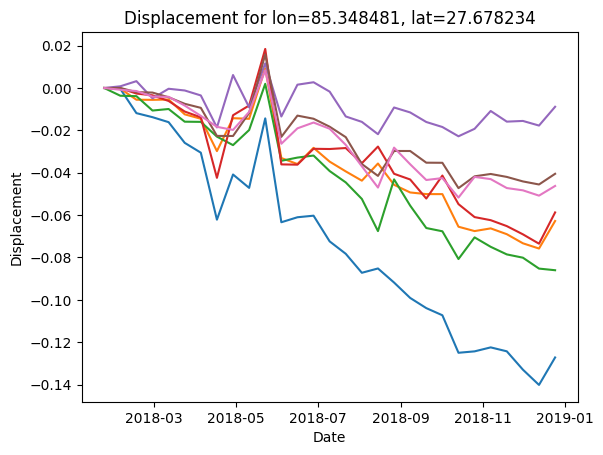

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

lon_values=[ 85.320254,85.290321,85.325961,85.285682,85.396056,85.336996,85.348481]
lat_values=[27.719888,27.705809,27.671760,27.720620, 27.686511,27.690337,27.678234]

plots = []
for lon, lat in zip(lon_values, lat_values):

    subset = disp_df.sel(latitude=lat, longitude=lon, method='nearest')

    plot, = plt.plot(subset['date'], subset['displacement'])
    plt.title(f'Displacement for lon={lon}, lat={lat}')
    plots.append(plot)

# plt.legend(plots, [f'lon={lon}, lat={lat}' for lon, lat in zip(lon_values, lat_values)])
plt.xlabel('Date')
plt.ylabel('Displacement')

plt.show()

Make animation of defortion time series.

In [ ]:
ds=disp_df

# Assuming 'ds' is your xarray.Dataset
# You may need to adjust the variable names accordingly
data_variable = ds['displacement']
latitudes = ds['latitude']
longitudes = ds['longitude']

# Existing code to create animation
fig, ax = plt.subplots()
plot = ax.imshow(data_variable[0, :, :], extent=[longitudes.min(), longitudes.max(), latitudes.min(), latitudes.max()],cmap=cmap)

plt.close()

def update(frame):
    plot.set_data(data_variable[frame, :, :])
    ax.set_title(f'Date: {ds["date"].values[frame]}')
    return plot,

ani = animation.FuncAnimation(fig, update, frames=len(ds['date']), interval=300, blit=True)

# Add color bar
cbar = fig.colorbar(plot, ax=ax)
cbar.set_label('Displacement [metre]')

rc('animation', html='jshtml')
ani

In [ ]:
# load in average velocity
vel_fn = 'velocity_RAW.h5'
vel_df = xr.open_dataset(vel_fn, engine='h5netcdf', phony_dims='sort', decode_coords="all")

# rebuild dataset
vel_df = vel_df.rename_dims({'phony_dim_0':'latitude',
                             'phony_dim_1':'longitude'})

vel_df = vel_df.assign_coords({'latitude': ('latitude', coord_range(vel_df, 'lat')),
                               'longitude': ('longitude', coord_range(vel_df, 'lon'))})

vel_df

<xarray.Dataset>
Dimensions:       (latitude: 126, longitude: 129)
Coordinates:
  * latitude      (latitude) float64 27.75 27.75 27.75 ... 27.65 27.65 27.65
  * longitude     (longitude) float64 85.28 85.28 85.28 ... 85.38 85.38 85.38
Data variables:
    intercept     (latitude, longitude) float32 ...
    interceptStd  (latitude, longitude) float32 ...
    residue       (latitude, longitude) float32 ...
    velocity      (latitude, longitude) float32 ...
    velocityStd   (latitude, longitude) float32 ...
Attributes: (12/81)
    ALOOKS:                                     7
    ANTENNA_SIDE:                               -1
    CENTER_LINE_UTC:                            44541.0
    DATA_TYPE:                                  float32
    DATE12:                                     20180123_20181225
    EARTH_RADIUS:                               6337286.638938101
    ...                                         ...
    mintpy.timeFunc.stepDate:                   []
    mintpy.timeFunc.timeSeriesCovFile:          None
    mintpy.timeFunc.uncertaintyQuantification:  residue
    orbitDirection:                             ASCENDING
    slantRangeSpacing:                          2.329562187194824
    startRange:                                 798980.125

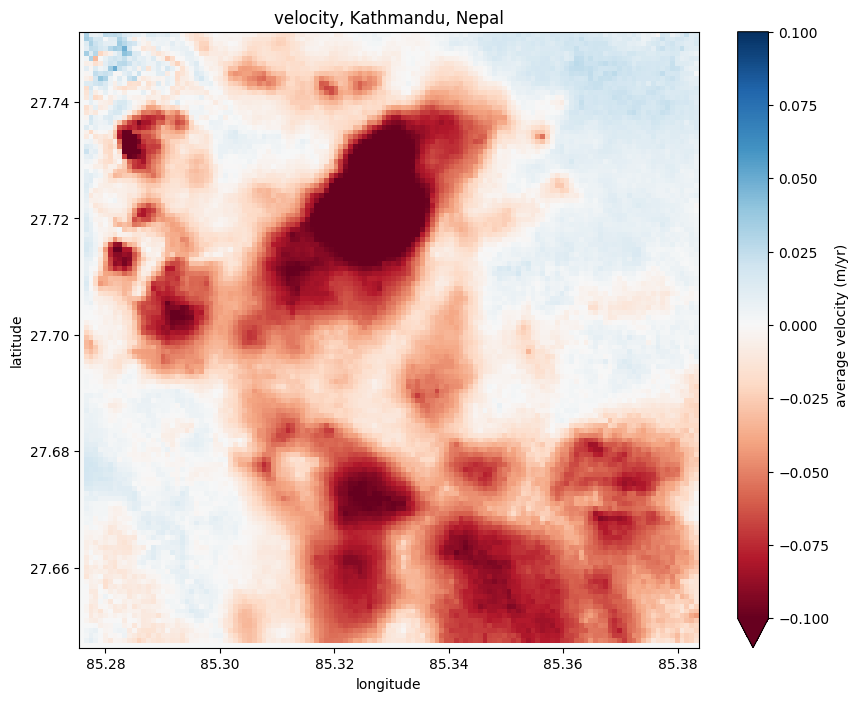

In [ ]:
f, ax = plt.subplots(figsize=(10,8))
vel_df.velocity.plot(ax=ax, cbar_kwargs={'label':'average velocity (m/yr)'}, vmin=-0.1, vmax=0.1, cmap='RdBu')
ax.set_title('velocity, Kathmandu, Nepal');